# 🧠 OASIS – Clasificación de Alzheimer con XGBoost

Este notebook implementa modelos de clasificación usando **XGBoost** para detectar Alzheimer en etapas tempranas a partir de características extraídas de imágenes de resonancia magnética del dataset OASIS.

## Objetivos
- **Clasificación multiclase**: Distinguir entre CN (Cognitivamente Normal), MCI (Deterioro Cognitivo Leve) y AD (Alzheimer)
- **Clasificación binaria**: Detectar si un paciente tiene deterioro cognitivo (MCI/AD) vs normal (CN)

## Pipeline
1. Carga del dataset de features extraídas
2. Preparación de datos (features y etiquetas)
3. División en conjuntos de entrenamiento, validación y prueba
4. Manejo de desbalance de clases
5. Entrenamiento de modelos XGBoost (multiclase y binario)
6. Evaluación de rendimiento
7. Guardado de modelos entrenados

## 1. Carga de datos

En esta sección cargamos las librerías necesarias y el dataset de características preprocesadas.

**Librerías utilizadas:**
- `pandas`, `numpy`: Manipulación de datos
- `matplotlib`, `seaborn`: Visualización
- `sklearn`: División de datos, métricas y preprocesamiento
- `xgboost`: Modelo de clasificación basado en árboles de decisión

El dataset contiene **features numéricas** extraídas de imágenes de MRI (grilla 16×16, proxies anatómicos, texturas, etc.) junto con las etiquetas de clase (CN, MCI, AD).

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

CSV_PATH = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\processed\features_oasis_coronal.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head()

Shape: (596, 534)


,filepath,label,f_458,f_92,f_126,f_460,f_348,f_470,f_290,f_442,f_372,f_312,f_440,f_388,f_324,f_284,f_280,f_370,f_472,f_258,f_410,f_434,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_200,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,f_210,f_211,f_212,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_281,f_282,f_283,f_285,f_286,f_287,f_288,f_289,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,f_300,f_301,f_302,f_303,f_304,f_305,f_306,f_307,f_308,f_309,f_310,f_311,f_313,f_314,f_315,f_316,f_317,f_318,f_319,f_320,f_321,f_322,f_323,f_325,f_326,f_327,f_328,f_329,f_330,f_331,f_332,f_333,f_334,f_335,f_336,f_337,f_338,f_339,f_340,f_341,f_342,f_343,f_344,f_345,f_346,f_347,f_349,f_350,f_351,f_352,f_353,f_354,f_355,f_356,f_357,f_358,f_359,f_360,f_361,f_362,f_363,f_364,f_365,f_366,f_367,f_368,f_369,f_371,f_373,f_374,f_375,f_376,f_377,f_378,f_379,f_380,f_381,f_382,f_383,f_384,f_385,f_386,f_387,f_389,f_390,f_391,f_392,f_393,f_394,f_395,f_396,f_397,f_398,f_399,f_400,f_401,f_402,f_403,f_404,f_405,f_406,f_407,f_408,f_409,f_411,f_412,f_413,f_414,f_415,f_416,f_417,f_418,f_419,f_420,f_421,f_422,f_423,f_424,f_425,f_426,f_427,f_428,f_429,f_430,f_431,f_432,f_433,f_435,f_436,f_437,f_438,f_439,f_441,f_443,f_444,f_445,f_446,f_447,f_448,f_449,f_450,f_451,f_452,f_453,f_454,f_455,f_456,f_457,f_459,f_461,f_462,f_463,f_464,f_465,f_466,f_467,f_468,f_469,f_471,f_473,f_474,f_475,f_476,f_477,f_478,f_479,f_480,f_481,f_482,f_483,f_484,f_485,f_486,f_487,f_488,f_489,f_490,f_491,f_492,f_493,f_494,f_495,f_496,f_497,f_498,f_499,f_500,f_501,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511,f_512,f_513,f_514,f_515,f_516,f_517,f_518,f_519,f_520,f_521,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,-0.937640,1.070091,0.720543,-0.895420,1.653419,-0.897521,1.079860,-0.960886,0.554381,0.196237,-0.886278,-0.829725,0.410757,0.428201,0.341225,1.015169,-0.900353,-0.003951,-0.777544,-0.631744,-0.941088,0.078861,-0.938237,0.088586,-0.946446,0.083849,-0.603710,0.709252,0.238158,1.556840,0.170087,1.286804,0.047764,1.011708,0.175264,0.967896,0.028956,0.995072,0.171440,0.969095,0.026514,0.995348,0.113926,1.247540,-0.161667,1.264034,-0.916812,0.095404,-0.951572,0.069847,-0.949734,0.070261,-0.926689,0.068053,-0.880960,0.137726,0.379179,1.558055,0.568308,1.476871,-0.116831,0.455321,0.102612,0.563714,-0.143720,0.539638,-0.076718,0.480998,-0.222371,0.405157,0.276683,0.574072,-0.113095,0.526242,-0.274075,0.484000,-0.084099,1.002445,0.594937,1.425104,-0.680665,0.695817,-0.973725,0.063409,-0.910901,0.132481,0.611033,1.351498,0.135391,1.187134,-0.2539

## Distribución de clases

Analizamos la distribución de las clases en el dataset para entender el desbalance. Esto es importante porque:
- **CN** (Cognitivamente Normal): Generalmente la clase más numerosa
- **MCI** (Deterioro Cognitivo Leve): Clase intermedia
- **AD** (Alzheimer): Generalmente la clase menos numerosa

El desbalance puede afectar el rendimiento del modelo, por lo que aplicaremos técnicas de balanceo más adelante.

In [3]:
df['label'].value_counts().to_frame('count').assign(
    pct=lambda d: 100*d['count']/d['count'].sum()
)

,count,pct
label,,
CN,350,58.724832
MCI,198,33.221477
AD,48,8.053691


## 2. Definir features y etiquetas

Preparamos los datos para el entrenamiento:

1. **Features (X)**: Seleccionamos todas las columnas que empiezan con `f_` (features numéricas extraídas)
2. **Etiquetas (y)**: Convertimos las etiquetas categóricas (CN, MCI, AD) a valores numéricos usando `LabelEncoder`:
   - CN → 0
   - MCI → 1
   - AD → 2

Esto es necesario porque XGBoost requiere etiquetas numéricas para la clasificación multiclase.

In [4]:
feature_cols=[c for c in df.columns if c.startswith('f_')]
X=df[feature_cols].values
y_labels=df['label'].values

le=LabelEncoder()
y_multi=le.fit_transform(y_labels)
dict(zip(le.classes_, le.transform(le.classes_)))

{'AD': np.int64(0), 'CN': np.int64(1), 'MCI': np.int64(2)}

## 3. Split Train / Val / Test

Dividimos el dataset en tres conjuntos:

1. **Training (70%)**: Para entrenar el modelo
2. **Validation (15%)**: Para ajustar hiperparámetros y monitorear el entrenamiento
3. **Test (15%)**: Para evaluar el rendimiento final (no se usa durante el entrenamiento)

Usamos `stratify` para mantener la proporción de clases en cada conjunto, lo cual es crucial dado el desbalance del dataset.

**Guardado de conjuntos:**
Los conjuntos divididos se guardan automáticamente en `data/splits/` como archivos `.npy` (numpy) para poder cargarlos posteriormente sin necesidad de volver a dividir el dataset:
- `X_train.npy`, `X_val.npy`, `X_test.npy` (features)
- `y_train.npy`, `y_val.npy`, `y_test.npy` (etiquetas)

In [ ]:
X_train,X_temp,y_train,y_temp=train_test_split(
    X,y_multi,test_size=0.3,stratify=y_multi,random_state=42)

X_val,X_test,y_val,y_test=train_test_split(
    X_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=42)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# Guardar los conjuntos en data/splits
BASE_DIR = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria"
SPLITS_DIR = os.path.join(BASE_DIR, "data", "splits")
os.makedirs(SPLITS_DIR, exist_ok=True)

# Guardar features (X)
np.save(os.path.join(SPLITS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SPLITS_DIR, "X_val.npy"), X_val)
np.save(os.path.join(SPLITS_DIR, "X_test.npy"), X_test)

# Guardar etiquetas (y)
np.save(os.path.join(SPLITS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SPLITS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(SPLITS_DIR, "y_test.npy"), y_test)

print(f"\n✓ Conjuntos guardados en: {SPLITS_DIR}")
print("  - X_train.npy, X_val.npy, X_test.npy")
print("  - y_train.npy, y_val.npy, y_test.npy")

((417, 532), (89, 532), (90, 532))

## 3.1. Manejo de desbalance

Calculamos **pesos de clase** para compensar el desbalance:

**Fórmula**: `peso_clase = total_muestras / (num_clases × muestras_clase)`

Esto hace que:
- Las clases minoritarias (AD) tengan **mayor peso** durante el entrenamiento
- Las clases mayoritarias (CN) tengan **menor peso**

XGBoost usará estos pesos (`sample_weight`) para dar más importancia a las muestras de clases desbalanceadas, mejorando la capacidad del modelo para detectar casos raros pero importantes (como AD).

In [6]:
unique,counts=np.unique(y_train,return_counts=True)
class_weights={cls: len(y_train)/(len(unique)*cnt) for cls,cnt in zip(unique,counts)}

sample_weight_train=np.array([class_weights[c] for c in y_train])
sample_weight_val=np.array([class_weights[c] for c in y_val])

class_weights

{np.int64(0): np.float64(4.088235294117647),
 np.int64(1): np.float64(0.5673469387755102),
 np.int64(2): np.float64(1.0072463768115942)}

## 4. Modelo XGBoost – Multiclase

Entrenamos un modelo XGBoost para **clasificación multiclase** (CN, MCI, AD).

**Hiperparámetros clave:**
- `n_estimators=400`: Número de árboles (más árboles = mejor rendimiento, pero más tiempo)
- `max_depth=5`: Profundidad máxima de cada árbol (previene sobreajuste)
- `learning_rate=0.05`: Tasa de aprendizaje (pasos pequeños = entrenamiento más estable)
- `subsample=0.9`: Usa 90% de muestras por árbol (reduce sobreajuste)
- `colsample_bytree=0.9`: Usa 90% de features por árbol (diversidad)
- `objective="multi:softprob"`: Clasificación multiclase con probabilidades
- `eval_metric="mlogloss"`: Métrica de evaluación (log-loss multiclase)

El modelo se entrena con los pesos calculados anteriormente para manejar el desbalance.

In [7]:
params_multi={
    "n_estimators":400,
    "max_depth":5,
    "learning_rate":0.05,
    "subsample":0.9,
    "colsample_bytree":0.9,
    "objective":"multi:softprob",
    "num_class":len(le.classes_),
    "eval_metric":"mlogloss",
    "tree_method":"hist",
    "random_state":42,
}

xgb_multi=XGBClassifier(**params_multi)

xgb_multi.fit(
    X_train,y_train,
    sample_weight=sample_weight_train,
    eval_set=[(X_val,y_val)],
    sample_weight_eval_set=[sample_weight_val],
    verbose=False
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


## 4.1. Evaluación multiclase

Evaluamos el modelo multiclase en el conjunto de prueba:

1. **Predicciones**: Clase predicha para cada muestra
2. **Probabilidades**: Probabilidad de pertenecer a cada clase (CN, MCI, AD)
3. **Classification Report**: Muestra precisión, recall y F1-score por clase
4. **Matriz de confusión**: Visualiza los aciertos y errores del modelo
5. **ROC-AUC macro**: Área bajo la curva ROC promedio (mide capacidad de discriminación)

**Interpretación:**
- **Precisión**: De los casos predichos como X, ¿cuántos realmente son X?
- **Recall**: De los casos reales de X, ¿cuántos detectó el modelo?
- **F1-score**: Balance entre precisión y recall

              precision    recall  f1-score   support

          AD       1.00      0.71      0.83         7
          CN       0.95      1.00      0.97        53
         MCI       1.00      0.97      0.98        30

    accuracy                           0.97        90
   macro avg       0.98      0.89      0.93        90
weighted avg       0.97      0.97      0.97        90



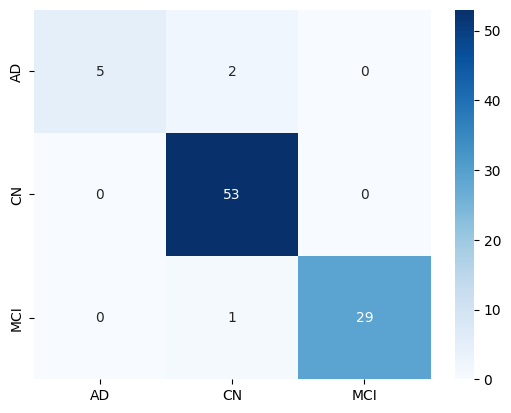

ROC-AUC macro: 0.9981422200949366


In [8]:
y_pred=xgb_multi.predict(X_test)
y_proba=xgb_multi.predict_proba(X_test)

print(classification_report(y_test,y_pred,target_names=le.classes_))

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=le.classes_,yticklabels=le.classes_)
plt.show()

try:
    print("ROC-AUC macro:", roc_auc_score(y_test,y_proba,multi_class='ovr'))
except:
    print("No se pudo calcular ROC multiclase.")

## 5. Modelo binario – CN vs MCI+AD

Entrenamos un segundo modelo para **clasificación binaria**:

- **Clase 0 (CN)**: Cognitivamente Normal
- **Clase 1 (MCI/AD)**: Cualquier forma de deterioro cognitivo

**¿Por qué un modelo binario?**
- A veces es más útil detectar si hay **cualquier deterioro** vs normalidad
- Puede tener mejor rendimiento al simplificar el problema
- Útil para screening inicial donde el objetivo es identificar pacientes que requieren atención

El proceso es similar al multiclase, pero con `objective="binary:logistic"` y pesos recalculados para las dos clases.

In [9]:
y_binary=(df['label']!='CN').astype(int).values

X_train_b,X_temp_b,y_train_b,y_temp_b=train_test_split(
    X,y_binary,test_size=0.3,stratify=y_binary,random_state=42)

X_val_b,X_test_b,y_val_b,y_test_b=train_test_split(
    X_temp_b,y_temp_b,test_size=0.5,stratify=y_temp_b,random_state=42)

unique_b,counts_b=np.unique(y_train_b,return_counts=True)
class_weights_b={cls:len(y_train_b)/(2*cnt) for cls,cnt in zip(unique_b,counts_b)}

sw_train_b=np.array([class_weights_b[c] for c in y_train_b])
sw_val_b=np.array([class_weights_b[c] for c in y_val_b])

params_bin={
    "n_estimators":400,
    "max_depth":5,
    "learning_rate":0.05,
    "subsample":0.9,
    "colsample_bytree":0.9,
    "objective":"binary:logistic",
    "eval_metric":"logloss",
    "tree_method":"hist",
    "random_state":42,
}

xgb_bin=XGBClassifier(**params_bin)

xgb_bin.fit(
    X_train_b,y_train_b,
    sample_weight=sw_train_b,
    eval_set=[(X_val_b,y_val_b)],
    sample_weight_eval_set=[sw_val_b],
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 5.1. Evaluación binaria

Evaluamos el modelo binario:

1. **Predicciones**: 0 (CN) o 1 (MCI/AD)
2. **Probabilidades**: Probabilidad de pertenecer a la clase positiva (MCI/AD)
3. **Classification Report**: Métricas para ambas clases
4. **Matriz de confusión**: Muestra verdaderos/falsos positivos y negativos
5. **ROC-AUC**: Área bajo la curva ROC (mide qué tan bien distingue entre CN y MCI/AD)

**Interpretación de la matriz de confusión:**
- **Verdaderos Negativos (CN→CN)**: Correctamente identificados como normales
- **Falsos Positivos (CN→MCI/AD)**: Falsas alarmas (normal clasificado como deterioro)
- **Falsos Negativos (MCI/AD→CN)**: Casos perdidos (deterioro clasificado como normal) ⚠️ **CRÍTICO**
- **Verdaderos Positivos (MCI/AD→MCI/AD)**: Correctamente detectados como deterioro

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        53
           1       0.92      0.92      0.92        37

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.93      0.93        90



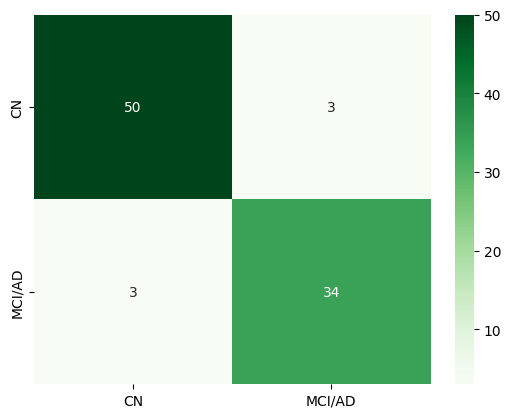

0.98419173890872

In [10]:
y_pred_b=xgb_bin.predict(X_test_b)
y_proba_b=xgb_bin.predict_proba(X_test_b)[:,1]

print(classification_report(y_test_b,y_pred_b))

cm_b=confusion_matrix(y_test_b,y_pred_b)
sns.heatmap(cm_b,annot=True,fmt='d',cmap='Greens',
            xticklabels=['CN','MCI/AD'],yticklabels=['CN','MCI/AD'])
plt.show()

roc_auc_score(y_test_b,y_proba_b)

## 6. Guardar modelos

Guardamos los modelos entrenados en formato JSON para uso posterior:

1. **xgb_multiclass_oasis.json**: Modelo para clasificación CN/MCI/AD
2. **xgb_binary_oasis.json**: Modelo para clasificación CN vs MCI/AD

**Uso futuro:**
Los modelos guardados pueden cargarse con `XGBClassifier.load_model()` para hacer predicciones en nuevos datos sin necesidad de reentrenar.

**Nota**: Asegúrate de que la carpeta `models` exista o se creará automáticamente.

In [11]:
BASE_DIR = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria"
MODEL_DIR = os.path.join(BASE_DIR, "models_saved")
os.makedirs(MODEL_DIR, exist_ok=True)

xgb_multi.save_model(os.path.join(MODEL_DIR, "xgb_multiclass_oasis.json"))
xgb_bin.save_model(os.path.join(MODEL_DIR, "xgb_binary_oasis.json"))

print("Modelos guardados en carpeta 'models_saved'")

Modelos guardados en carpeta 'models_saved'
